# Opdracht 2 - Convolutional Neural Networks


Het doel van deze opdracht is om image recognition te doen aan de hand van Convolutional Neural Networks (CNN). In een eerste deelopdracht ontwerp je een binaire CNN classifier voor het classificeren van foto's van lichaamscellen die al dan niet met malaria geïnfecteerd zijn. 

In een tweede deelopdracht zal je gezichtsherkenning uitvoeren via een multi-class CNN classifier.

In een derde deelopdracht train je een CNN die gezichten van niet-gezichten kan onderscheiden. Met deze classifier kan je vervolgens gezichtsdetectie uitvoeren. Daarbij is het niet de bedoeling om gezichten te herkennen, maar de locatie van al dan niet aanwezig gezichten in afbeeldingen te vinden en aan te duiden.

Na deze opdracht zal je vertrouwd zijn met:
- Implementeren van convolutional neural networks voor objectherkenning in afbeeldingen.
- Hyperparameter tuning van CNN's
- Weten hoe je transfer learning kan toepassen voor jouw eigen classificatie taak.
- Data/Image augmentation uitvoeren.
- Object detectie via een sliding window.


In [1]:
%matplotlib inline
import os
from pathlib import Path
from datetime import datetime
import pytz
import time
from datetime import datetime
import re

# Graphics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from termcolor import (
    colored,
    cprint,
)
import matplotlib.image as mpimg
from skimage.io import imread, imshow

# Data
import numpy as np
import pandas as pd

# SKLearn
from sklearn.datasets import (
    make_blobs,
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn import preprocessing
from sklearn.preprocessing import (
    LabelBinarizer,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    auc,
    roc_curve,
    RocCurveDisplay,
)

from sklearn.utils import (
    class_weight,
    shuffle,
)

from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
import sklearn.metrics as metrics
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    AveragePooling2D,
    BatchNormalization,
    Dense,
    Dropout,
    Flatten,
    Input, 
    BatchNormalization,
    Conv2D, MaxPooling2D,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import (
    relu,
    leaky_relu,
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

# Some defaults for matplotlib
LARGE = 12
MEDIUM = 10
SMALL = 6
plt.tight_layout()
plt.rcParams.update({
    'axes.titlesize': MEDIUM,
    'legend.fontsize': SMALL,
    'figure.figsize': (5, 3),
    'axes.labelsize': MEDIUM,
    'axes.titlesize': MEDIUM,
    'xtick.labelsize': SMALL,
    'ytick.labelsize': SMALL,
    'figure.titlesize': LARGE
})

# Reproducibility of the results
SEED = 42
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

#K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

###### Voor Tensorflow-GPU ########
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)


2025-04-10 08:23:24.176319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 08:23:24.188024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744266204.203013    2392 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744266204.206808    2392 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 08:23:24.220629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<Figure size 640x480 with 0 Axes>

### Display info

In [2]:
# Display Helpers
def display_title(title, value=None):
    if value is None:
        cprint(title, "black", "on_cyan")
    else:
        print(colored(title, "blue"))
        print(value)

def display_value(title, value):
    print(f"{colored(title, "blue")}: {value}")


### Metrics

In [3]:
# Metrics
def print_metrics(model, X_test, y_test, title="Results"):
    display_title(title)
    y_pred_proba = model.predict(X_test)
    y_pred_class = np.argmax(y_pred_proba, axis=1)

    display_title("classification report", classification_report(y_test, y_pred_class))
    display_title("confusion matrix", confusion_matrix(y_test, y_pred_class))
    display_value("Accuracy score", (accuracy_score(y_test, y_pred_class) * 100))


### Information Plots

## Malaria Classification

Ontwerp en train een CNN dat is in staat is met Malaria geïnfecteerde cellen van niet-geïnfecteerde cellen te onderscheiden.

De data is te vinden in:
- './Malaria/train/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te trainen.
- './Malaria/train/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te trainen.
- './Malaria/test/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te testen.
- './Malaria/test/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te testen.


1. Ontwerp in eerste instantie een eigen CNN. 
- Probeer de accuracy van het CNN op de test data zo hoog mogelijk te krijgen. Dit kan bijvoorbeeld omvatten: hyperparameter tuning van de het netwerk zelf, early stopping, image augmentation of eigen bedachte (pre)-processing technieken. 
- Stel nu dat aan het CNN de vereiste wordt gesteld dat het aantal false negatives (het netwerk voorspelt niet-geïnfecteerd terwijl ze wel geïnfecteerd zijn) op de test set maximaal 1% mag bedragen. Welke aanpassingen zou je doen? Voor deze aanpassingen uit en toon aan dat het aantal false negatives tot maximum 1% is gezakt. Welke accuracy haal je nog?

2. Voer transfer learning uit. Hertrain het VGG19 netwerk voor het classificeren van de al dan niet met Malaria geïnfecteerde cellen. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.



In [4]:
# Plotting
# TODO: Hier zou ik ook alle metrics kunnen plotten
def plot_history(history, training_time, title="Results"):
    """Plot error and accuracy of model.fit """
    print("--->",history.history.keys()) 
    if "false_negatives_50pct" in history.history.keys():
        fig, axes = plt.subplots(1, 3, figsize = (18, 3), sharey=False)
    else:
        fig, axes = plt.subplots(1, 2, figsize = (12, 3), sharey=False)

    # Loss (Training error)
    axes[0].set_title("Loss")
    axes[0].plot(history.epoch, history.history["loss"], "red", linewidth=2.0, label="training loss")
    axes[0].plot(history.epoch, history.history['val_loss'],'blue',linewidth=2.0, label="validation loss")
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].grid()
    axes[0].legend(loc='upper right')
    
    # Accuracy
    if "accuracy" in history.history.keys():
        key = "accuracy"
    if "binary_accuracy" in history.history.keys():
        key = "binary_accuracy"
        
    axes[1].set_title("Accuracy")
    axes[1].plot(history.epoch, history.history[key], "red", linewidth=2.0, label=f"training {key}")
    axes[1].plot(history.epoch, history.history[f"val_{key}"],'blue',linewidth=2.0, label=f"validation {key}")
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel(key)
    axes[1].grid()
    axes[1].legend(loc="lower right")

    if "false_negatives_50pct" in history.history.keys():
        axes[2].set_title("False Negatives")
        axes[2].plot(history.epoch, history.history["false_negatives_50pct"], "red", linewidth=1.5, linestyle="dashed", label="training False Negatives 0.5")
        axes[2].plot(history.epoch, history.history["val_false_negatives_50pct"],'blue',linewidth=1.5, linestyle="dashed", label="validation False Negatives 0.5")
        if "false_negatives_99pct" in history.history.keys():
            axes[2].plot(history.epoch, history.history["false_negatives_99pct"], "red", linewidth=1.5, label="training False Negatives 0.99")
            axes[2].plot(history.epoch, history.history["val_false_negatives_99pct"],'blue',linewidth=1.5, label="validation False Negatives 0.99")
        axes[2].set_xlabel("epoch")
        axes[2].set_ylabel("false negatives")
        axes[2].grid()
        axes[2].legend(loc="upper right")
        
    # Overall title
    fig.suptitle(f"{title}: ({training_time:.5f})", verticalalignment="top")

    # show
    plt.show()

### Eigen CNN (exploratie)

In [5]:
# Inlezen van de data
# Reading images
def read_images(path, nbr_images, image_size, label):
    valid_image_extensions = [".jpg", ".gif", ".png"]
    selected_images = []
    labels = []
    nbr_of_images_collected = 0
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_image_extensions:
            continue
        if nbr_of_images_collected >= nbr_images:
            break
        im = imread(os.path.join(path, f))
        im = transform.resize(im, (image_size, image_size), mode='constant', anti_aliasing=True)
        selected_images.append(im)
        labels.append(label)
        nbr_of_images_collected = nbr_of_images_collected+1

    return selected_images, labels
    
# Creëer een training set en test set. Zorg ervoor dat 30 procent van de afbeeldingen in de test set zitten.
def read_malaria_input(sample_size=1000, image_size=100):
    ROOT_PATH = Path("")

    infected_train_images, y_infected_train = read_images(ROOT_PATH / "./Malaria/train/infected", sample_size, image_size, 1)
    infected_test_images, y_infected_test = read_images(ROOT_PATH / "./Malaria/test/infected", sample_size, image_size, 1)
    uninfected_train_images, y_uninfected_train = read_images(ROOT_PATH / "./Malaria/train/uninfected", sample_size, image_size, 0)
    uninfected_test_images, y_uninfected_test = read_images(ROOT_PATH / "./Malaria/test/uninfected",sample_size, image_size, 0)
    display_title("Infected == 1 and Uninfected == 0")

    # collect some sample images to display
    samples_infected = [infected_train_images[0], infected_test_images[4]]
    samples_uninfected = [uninfected_train_images[0], uninfected_test_images[4]]

    # Mix de infected en niet infected
    X_train, y_train = shuffle(uninfected_train_images + infected_train_images,  y_uninfected_train + y_infected_train, random_state=0)
    X_test, y_test = shuffle(uninfected_test_images + infected_test_images,  y_uninfected_test + y_infected_test, random_state=1)

    # convert to numpy arrays
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    print(type(X_train), y_train[0:20])
    return X_train, y_train, X_test, y_test, samples_infected, samples_uninfected
    
# Input sizes
image_size = 50                      # hoogte en breedte van de afbeeldingen na resizing. Pas gerust aan.
nr_train_images_per_category = 2000  # Om het aantal afbeelding in de training set te beperken. Verhoog indien jouw systeem het toelaat.
                                     # om het eenvoudig te houden nemen we evenveel test als train images

# read the imnages
X_train, y_train, X_test, y_test, samples_infected, samples_uninfected = read_malaria_input(sample_size=nr_train_images_per_category, image_size=image_size)
display_value(f"X_train shape", X_train.shape)    
display_value(f"y_train shape", y_train.shape)    
display_value(f"X_test shape", X_train.shape)    
display_value(f"y_test shape", y_train.shape)    
display("")
display_value(f"sample y_train {type(y_train)}", y_train[0:20])    
display_value(f"sample y_test {type(y_test)}", y_test[0:20])    
    


Infected == 1 and Uninfected == 0
<class 'numpy.ndarray'> [1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1]
X_train shape: (4000, 50, 50, 3)
y_train shape: (4000,)
X_test shape: (4000, 50, 50, 3)
y_test shape: (4000,)


''

sample y_train <class 'numpy.ndarray'>: [1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1]
sample y_test <class 'numpy.ndarray'>: [0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0]


Text(0.5, 0.98, '50x50')

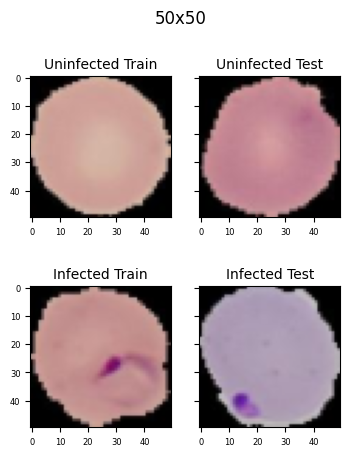

In [6]:
# Toon een aantal afbeeldingen afbeelding
fig_vb, axes_vb = plt.subplots(2, 2, figsize = (4, 5), sharey=True)
axes_vb[0,0].set_title("Uninfected Train")
axes_vb[0,0].imshow(samples_uninfected[0])
axes_vb[0,1].set_title("Uninfected Test")
axes_vb[0,1].imshow(samples_uninfected[1])
axes_vb[1,0].set_title("Infected Train")
axes_vb[1,0].imshow(samples_infected[0])
axes_vb[1,1].set_title("Infected Test")
axes_vb[1,1].imshow(samples_infected[1])
fig_vb.suptitle(f"{image_size}x{image_size}")


In [7]:
# Normalisatie van de data
display_value("example image shape", X_train[0].shape)
display_value("min in an image", np.amin(X_train[0]))
display_value("max in an image", np.amax(X_train[0]))
display_value("min all training images", np.amin(X_train))
display_value("max all images", np.amax(X_train))
# De data lijkt reeds genormaliseerd te zijn


example image shape: (50, 50, 3)
min in an image: 0.0
max in an image: 0.8852432762662961
min all training images: 0.0
max all images: 0.9958680811571734


In [8]:
# CNN Architecture
def build_malaria_model(input_shape=(100, 100, 3)):
    # Model
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # Feature Extraction Layers
    # Strides=(1,1), padding="valid"
    model.add(Conv2D(filters=16, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.activations.relu))

    model.add(Conv2D(filters=32, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.activations.relu))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.layers.ReLU(negative_slope=0.0)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.layers.ReLU(negative_slope=0.0)))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Prepare for classification
    model.add(Flatten())

    # Classification Layers
    model.add(Dense(units=64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  # Explicit activation

    model.add(Dense(units=32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  # Explicit activation

    # Add an output layer for binary classification
    model.add(Dense(units=1))  # Single unit for binary classification
    model.add(Activation('sigmoid'))

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        # metrics=['accuracy'],
        metrics=[
            # tf.keras.metrics.Accuracy(),
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.TrueNegatives(thresholds=0.5, name="true_negatives_50pct"),
            tf.keras.metrics.TruePositives(thresholds=0.5, name="true_positives_50pct"),
            tf.keras.metrics.FalseNegatives(thresholds=0.5, name="false_negatives_50pct"),
            tf.keras.metrics.FalsePositives(thresholds=0.5, name="false_positives_50pct"),
            tf.keras.metrics.TrueNegatives(thresholds=0.99, name="true_negatives_99pct"),
            tf.keras.metrics.TruePositives(thresholds=0.99, name="true_positives_99pct"),
            tf.keras.metrics.FalseNegatives(thresholds=0.99, name="false_negatives_99pct"),
            tf.keras.metrics.FalsePositives(thresholds=0.99, name="false_positives_99pct"),
        ],
    )
    return model

malaria_model = build_malaria_model(input_shape=(image_size, image_size, 3))
print(malaria_model.summary())

I0000 00:00:1744036503.451211  644031 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3574 MB memory:  -> device: 0, name: NVIDIA RTX A3000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            3

 Total params: 395,553 (1.51 MB)

 Trainable params: 395,009 (1.51 MB)

 Non-trainable params: 544 (2.12 KB)

None


Epoch 1/50


I0000 00:00:1744036508.330206  644250 cuda_dnn.cc:529] Loaded cuDNN version 90300


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - binary_accuracy: 0.7105 - false_negatives_50pct: 228.0891 - false_negatives_99pct: 820.5148 - false_positives_50pct: 200.5049 - false_positives_99pct: 0.0000e+00 - loss: 0.5686 - precision: 0.7187 - true_negatives_50pct: 607.1485 - true_negatives_99pct: 807.6534 - true_positives_50pct: 595.9406 - true_positives_99pct: 3.5149 - val_binary_accuracy: 0.5138 - val_false_negatives_50pct: 389.0000 - val_false_negatives_99pct: 389.0000 - val_false_positives_50pct: 0.0000e+00 - val_false_positives_99pct: 0.0000e+00 - val_loss: 0.9973 - val_precision: 0.0000e+00 - val_true_negatives_50pct: 411.0000 - val_true_negatives_99pct: 411.0000 - val_true_positives_50pct: 0.0000e+00 - val_true_positives_99pct: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - binary_accuracy: 0.8768 - false_negatives_50pct: 100.6436 - false_negatives_99pct: 769.8416 - false_positives_50pct: 86.7228 - false_positives_99pct: 0.0000e+00 - lo

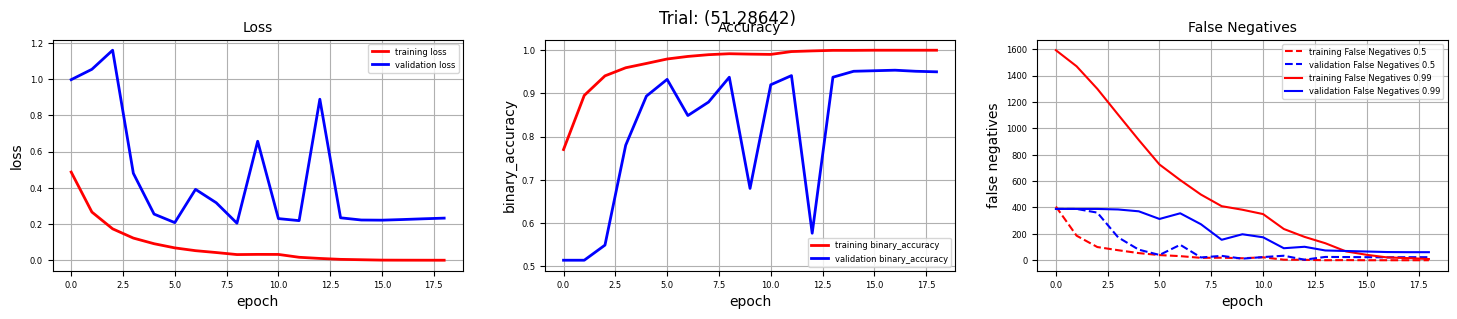

In [9]:
# CNN Training
def train_malaria_model(model, X_train_input, y_train_input, description, verbose=1):
    # Stop training when no further improvement is seen in the metric
    early_stop = EarlyStopping(
        monitor="val_loss",    # metric to monitor
        patience=10,           # stop when no improvement after 10 consecutive epochs
        mode="min",            # stop when metric stops decreasing
        restore_best_weights=True,
        verbose=verbose,             # display the actions taken
    )
    # Callback to save the Keras model or model weights at some frequency
    checkpoint = ModelCheckpoint(
        filepath="malaria.keras",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_freq="epoch",
        verbose=verbose,             # display the actions taken
    )
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr_on_plateau = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        mode="min",
        # min_delta=0.0001,
        # cooldown=0,
        min_lr=1e-6,
        verbose=verbose,             # display the actions taken
    )
    # Save output to be used with tensorboard
    tensorboard = TensorBoard(
        log_dir=f"logs/malaria_{description}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    )

    # Train the model
    start_timing = time.time()
    history = model.fit(
        x=X_train_input,
        y=y_train_input,
        batch_size=32,
        epochs=50,
        validation_split=0.2,
        verbose=verbose,             # display the actions taken
        callbacks=[early_stop, reduce_lr_on_plateau, tensorboard],
    )
    end_timing = time.time()
    return history, end_timing - start_timing

history, training_time = train_malaria_model(model=malaria_model, X_train_input=X_train, y_train_input=y_train, description="example")
display_value("Training time", training_time) 
plot_history(history, training_time, "Trial")    

In [10]:
# Testen van het neuraal netwerk op de test set. Kijk naar de accuracy, recall, precision, f1-score en de ROC 
# method I: plt
def plot_roc_curve(model, X_test_input, y_test_input):

    y_pred_proba = model.predict(X_test_input).flatten()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_input, y_pred_proba, pos_label=1)
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    display_value("AUC", area_under_curve)

    # ROC
    fig, ax = plt.subplots(figsize = (6, 3), sharey=False)
    ax.set_title("Receiver Operating Characteristic: Infected TRUE")
    ax.plot(false_positive_rate, true_positive_rate, color="blue", label = f"AUC = {area_under_curve}")
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid()
    ax.legend(loc='upper right')
    plt.show()

def print_binary_metrics(model, X_test_input, y_test_input, decision_boundary=0.5, title="Binary Results"):
    display_title(f"{title} - Treshold({decision_boundary})")
    y_pred_proba = model.predict(X_test_input).flatten()
    y_pred_class = (y_pred_proba >= decision_boundary).astype(int)

    display_title("Scikit learn metrics")
    display_title("classification report", classification_report(y_test_input, y_pred_class))
    display_title("confusion matrix",confusion_matrix(y_test_input, y_pred_class, labels=[0, 1]))
    display("    p0 p1")
    display("a0: TN FP")
    display("a1: FN TP")
    display_value("Accuracy score", (accuracy_score(y_test_input, y_pred_class) * 100))
    display("")
    display_title("Tensorflow evaluate")
    metrics = model.evaluate(X_test_input, y_test_input, return_dict=True)
    for m,v in metrics.items():
        display_value(m, v)
    display("-----------------------------------------")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC: 0.99385225


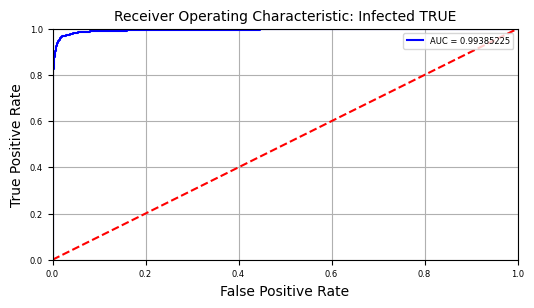

Training Set - Treshold(0.5)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2000
           1       0.99      0.95      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

confusion matrix
[[1973   27]
 [ 102 1898]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 96.775


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9713 - false_negatives_50pct: 48.0714 - false_negatives_99pct: 373.7460 - false_positives_50pct: 6.9524 - false_positives_99pct: 0.1905 - loss: 0.0804 - precision: 0.9948 - true_negatives_50pct: 1016.9127 - true_negatives_99pct: 1023.6746 - true_positives_50pct: 959.8095 - true_positives_99pct: 634.1349
binary_accuracy: 0.9677500128746033
false_negatives_50pct: 102.0
false_negatives_99pct: 761.0
false_positives_50pct: 27.0
false_positives_99pct: 2.0
loss: 0.09668231755495071
precision: 0.9859740138053894
true_negatives_50pct: 1973.0
true_negatives_99pct: 1998.0
true_positives_50pct: 1898.0
true_positives_99pct: 1239.0


'-----------------------------------------'

Test Set - Treshold(0.5)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2000
           1       0.96      0.91      0.93      2000

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000

confusion matrix
[[1928   72]
 [ 186 1814]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 93.55


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9323 - false_negatives_50pct: 95.8413 - false_negatives_99pct: 408.3810 - false_positives_50pct: 38.4921 - false_positives_99pct: 6.8413 - loss: 0.2211 - precision: 0.9545 - true_negatives_50pct: 986.9921 - true_negatives_99pct: 1018.6429 - true_positives_50pct: 910.4207 - true_positives_99pct: 597.8810
binary_accuracy: 0.9355000257492065
false_negatives_50pct: 186.0
false_negatives_99pct: 812.0
false_positives_50pct: 72.0
false_positives_99pct: 13.0
loss: 0.2137746959924698
precision: 0.9618239402770996
true_negatives_50pct: 1928.0
true_negatives_99pct: 1987.0
true_positives_50pct: 1814.0
true_positives_99pct: 1188.0


'-----------------------------------------'

'----------------------------------------------------------------------------------'

Training Set - Treshold(0.99)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2000
           1       1.00      0.62      0.76      2000

    accuracy                           0.81      4000
   macro avg       0.86      0.81      0.80      4000
weighted avg       0.86      0.81      0.80      4000

confusion matrix
[[1998    2]
 [ 761 1239]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 80.925


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9713 - false_negatives_50pct: 48.0714 - false_negatives_99pct: 373.7460 - false_positives_50pct: 6.9524 - false_positives_99pct: 0.1905 - loss: 0.0804 - precision: 0.9948 - true_negatives_50pct: 1016.9127 - true_negatives_99pct: 1023.6746 - true_positives_50pct: 959.8095 - true_positives_99pct: 634.1349
binary_accuracy: 0.9677500128746033
false_negatives_50pct: 102.0
false_negatives_99pct: 761.0
false_positives_50pct: 27.0
false_positives_99pct: 2.0
loss: 0.09668231755495071
precision: 0.9859740138053894
true_negatives_50pct: 1973.0
true_negatives_99pct: 1998.0
true_positives_50pct: 1898.0
true_positives_99pct: 1239.0


'-----------------------------------------'

Test Set - Treshold(0.99)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2000
           1       0.99      0.59      0.74      2000

    accuracy                           0.79      4000
   macro avg       0.85      0.79      0.79      4000
weighted avg       0.85      0.79      0.79      4000

confusion matrix
[[1987   13]
 [ 812 1188]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 79.375


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9323 - false_negatives_50pct: 95.8413 - false_negatives_99pct: 408.3810 - false_positives_50pct: 38.4921 - false_positives_99pct: 6.8413 - loss: 0.2211 - precision: 0.9545 - true_negatives_50pct: 986.9921 - true_negatives_99pct: 1018.6429 - true_positives_50pct: 910.4207 - true_positives_99pct: 597.8810
binary_accuracy: 0.9355000257492065
false_negatives_50pct: 186.0
false_negatives_99pct: 812.0
false_positives_50pct: 72.0
false_positives_99pct: 13.0
loss: 0.2137746959924698
precision: 0.9618239402770996
true_negatives_50pct: 1928.0
true_negatives_99pct: 1987.0
true_positives_50pct: 1814.0
true_positives_99pct: 1188.0


'-----------------------------------------'

'=================================================================================='

In [11]:
# Testen van het neuraal netwerk op de test set. Kijk naar de accuracy, recall, precision, f1-score en de ROC

# Hier zijn enkele vergelijkingen gemaakt met de metrics in sklearn en tensorflow(keras)
# Plot ROC
plot_roc_curve(model=malaria_model, X_test_input=X_train, y_test_input=y_train)

# Metrics on the training set
print_binary_metrics(model=malaria_model, X_test_input=X_train, y_test_input=y_train, decision_boundary=0.5, title="Training Set")
# Metrics on the test set
print_binary_metrics(model=malaria_model, X_test_input=X_test, y_test_input=y_test, decision_boundary=0.5, title="Test Set")
display("----------------------------------------------------------------------------------")

# Metrics on the training set
print_binary_metrics(model=malaria_model, X_test_input=X_train, y_test_input=y_train, decision_boundary=0.99, title="Training Set")
# Metrics on the test set
print_binary_metrics(model=malaria_model, X_test_input=X_test, y_test_input=y_test, decision_boundary=0.99, title="Test Set")
display("==================================================================================")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[0.00182656 0.0017572  0.00964343 ... 0.8582545  0.00372135 0.00283715]
[0 1]
[2799 1201]
[0 0 0 ... 0 0 0]
13
812
Examples of False Positives (not-infected, but predicted as infected)


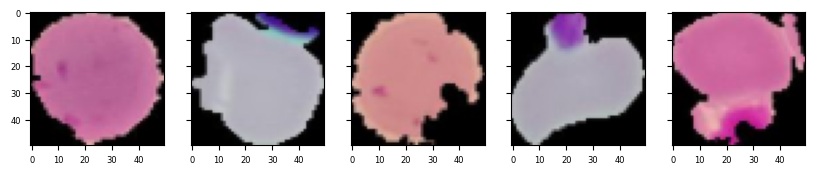

Examples of False Negatives (infected, but predicted as not-infected)


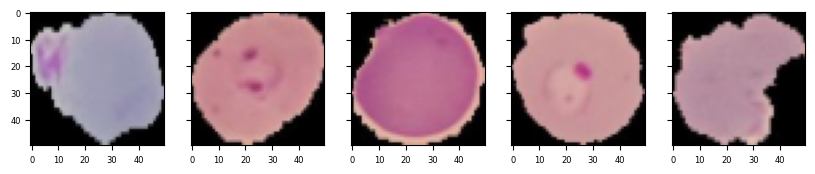

In [12]:
# Visualiseer enkele verkeerd geclassificeerde afbeeldingen van de ene klasse en van de andere klasse. 
y_pred_proba_test = malaria_model.predict(X_test).flatten()
print(y_pred_proba_test)
y_pred_class_test = (y_pred_proba_test >= 0.99).astype(int)
a, b = np.unique(y_pred_class_test, return_counts=True)
print(a)
print(b)
print(y_pred_class_test)

X_test_fp = X_test[(y_test == 0) & (y_pred_class_test == 1)]
X_test_fn = X_test[(y_test == 1) & (y_pred_class_test == 0)]
print(len(X_test_fp))
print(len(X_test_fn))

display_title("Examples of False Positives (not-infected, but predicted as infected)")
_, axes_fp_test = plt.subplots(1, 5, figsize = (10, 2), sharey=True)
for i in range(min([5, len(X_test_fp)])):
    axes_fp_test[i].imshow(X_test_fp[i])
plt.show()

display_title("Examples of False Negatives (infected, but predicted as not-infected)")
_, axes_fn_test = plt.subplots(1, 5, figsize = (10, 2), sharey=True)
for i in range(min([5, len(X_test_fn)])):
    axes_fn_test[i].imshow(X_test_fn[i])
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[0.9994289  0.02379832 0.9925687  ... 0.01672038 0.8818448  0.7157917 ]
[0 1]
[2759 1241]
[1 0 1 ... 0 0 0]
2
761
Examples of False Positives (not-infected, but predicted as infected)


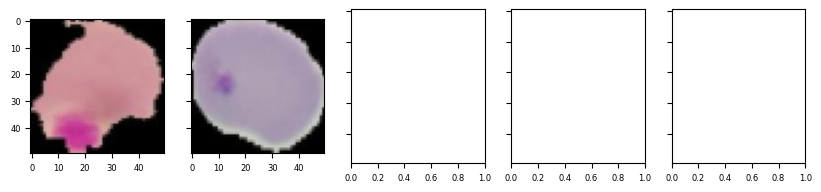

Examples of False Negatives (infected, but predicted as not-infected)


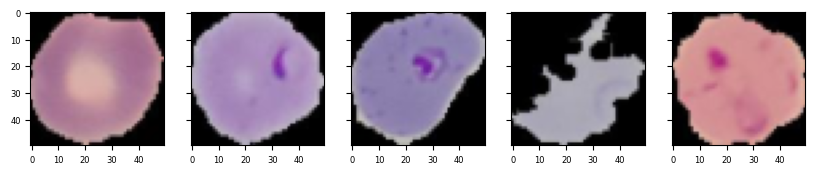

In [13]:
# Visualiseer enkele verkeerd geclassificeerde afbeeldingen van de ene klasse en van de andere klasse. 
y_pred_proba_train = malaria_model.predict(X_train).flatten()
print(y_pred_proba_train)
y_pred_class_train = (y_pred_proba_train >= 0.99).astype(int)
a, b = np.unique(y_pred_class_train, return_counts=True)
print(a)
print(b)
print(y_pred_class_train)

X_train_fp = X_train[(y_train == 0) & (y_pred_class_train == 1)]
X_train_fn = X_train[(y_train == 1) & (y_pred_class_train == 0)]
print(len(X_train_fp))
print(len(X_train_fn))

display_title("Examples of False Positives (not-infected, but predicted as infected)")
_, axes_fp_train = plt.subplots(1, 5, figsize = (10, 2), sharey=True)
for i in range(min([5, len(X_train_fp)])):
    axes_fp_train[i].imshow(X_train_fp[i])
plt.show()

display_title("Examples of False Negatives (infected, but predicted as not-infected)")
_, axes_fn_train = plt.subplots(1, 5, figsize = (10, 2), sharey=True)
for i in range(min([5, len(X_train_fn)])):
    axes_fn_train[i].imshow(X_train_fn[i])
plt.show()


---

### Zoektocht naar een beter model

In [14]:
# Optimalisatie van het netwerk

def collect_accuracy(model, X_train_input, y_train_input, X_test_input, y_test_input, decision_boundary=0.5, verbose=1):
    # Train accuracy
    y_train_pred_proba = model.predict(X_train_input, verbose=verbose).flatten()
    y_train_pred_class = (y_train_pred_proba >= decision_boundary).astype(int)
    train_accuracy = accuracy_score(y_train_input, y_train_pred_class) * 100

    # Test accuracy
    y_test_pred_proba = model.predict(X_test_input, verbose=verbose).flatten()
    y_test_pred_class = (y_test_pred_proba >= decision_boundary).astype(int)
    test_accuracy = accuracy_score(y_test_input, y_test_pred_class) * 100

    display_value(f"Accuracy - ({model.howest}) - Threshold({decision_boundary:.2f})", f"Train({train_accuracy:.2f})\tTest({test_accuracy:.2f})")
    return getattr(model, "howest", "xx"), decision_boundary, train_accuracy, test_accuracy

def model_explorer(name, input_shape, feature_extractor, classifier, skip=False):
    if skip:
        return None
        
    # Create a model from a simplified description
    model = Sequential()
    # Input Layer
    model.add(Input(shape=input_shape))
    
    # Feature Extraction Layers
    for fl in feature_extractor:
        match fl:
            case ("C", filters):
                model.add(Conv2D(filters=filters, kernel_size=(3, 3)))
            case ("A", "relu"):
                model.add(Activation(tf.keras.activations.relu))
            case ("A", "leaky_relu"):
                model.add(Activation(tf.keras.activations.leaky_relu))
            case "B":
                model.add(BatchNormalization())
            case ("Dr", rate):
                model.add(Dropout(rate=rate))
            case ("P", "max"):
                model.add(MaxPooling2D(pool_size=(2, 2)))
            case ("P", "avg"):
                model.add(AveragePooling2D(pool_size=(2, 2)))
            case x:
                print(f"Unknown layer type {x}")

    # Prepare for classification
    # Flatten the output of the feature extraction layers
    model.add(Flatten())

    # Classification Layers 
    for cl in classifier:
        match cl:
            case ("D", units):
                model.add(Dense(units=units))
            case ("A", activation):
                model.add(Activation(activation))
            case "B":
                model.add(BatchNormalization())
            case ("Dr", rate):
                model.add(Dropout(rate=rate))
            case x:
                print(f"Unknown layer type {x}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'],
        # metrics=[
        #     keras.metrics.BinaryAccuracy(),
        #     keras.metrics.FalseNegatives(),
        # ],
    )
    setattr(model, "howest", name)

    return model



In [15]:
# Some models to see what the effects are
image_shape = (image_size, image_size, 3)

malaria_models = [
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 01",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 128), "B", ("A", "relu"),
            ("D", 64), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 02",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 03",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "avg"),
            ("C", 64), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "avg"),
            ("C", 32), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "avg"),
        ],
        classifier=[
            ("D", 128), "B", ("A", "relu"),
            ("D", 64), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 04",
        input_shape=(image_size, image_size, 3),
        feature_extractor=[
            ("C", 128), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 32), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
        ],
        classifier=[
            ("D", 128), "B", ("A", "relu"),
            ("D", 64), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 05",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 32), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
        ],
        classifier=[
            ("D", 128), "B", ("A", "relu"),
            ("D", 64), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 06",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 256), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 128), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 32), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("P", "max"),
        ],
        classifier=[
            ("D", 128), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("D", 64), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 07",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 08",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 09",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 10",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 11",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 12",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 13",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 14",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), "B", ("A", "relu"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 64), "B", ("A", "relu"),
            ("C", 64), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), "B", ("A", "relu"),
            ("D", 32), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 15",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 8), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 16), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("D", 1024), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 16",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 8), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 16), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 32), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("D", 1024), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 17",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 8), "B", ("A", "leaky_relu"),
            ("P", "max"),
            ("C", 16), "B", ("A", "leaky_relu"),
            ("P", "max"),
            ("C", 32), "B", ("A", "leaky_relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("D", 1024), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 18",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 128), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 256), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 128), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("D", 128), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 19",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 256), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 256), "B", ("A", "relu"),
            ("P", "max"),
            ("C", 128), "B", ("A", "relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), "B", ("A", "relu"),
            ("Dr", 0.3),
            ("D", 512), "B", ("A", "relu"),
            ("D", 64), "B", ("A", "relu"),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
]


Session: 0-Exploration (50x50) 01
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


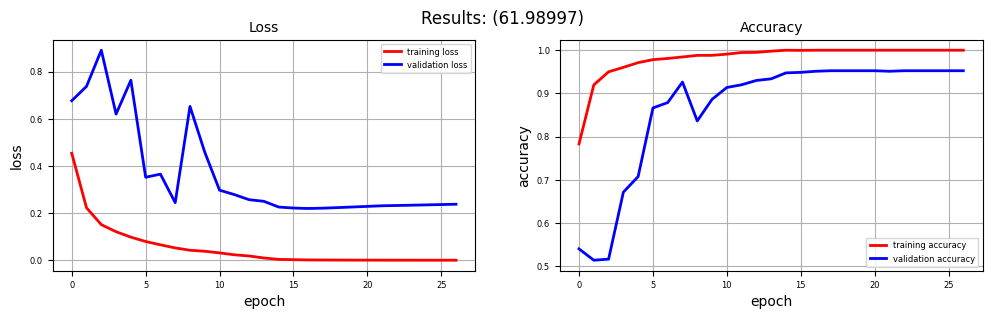

Accuracy - (Exploration (50x50) 01) - Threshold(0.50): Train(98.62)	Test(94.30)
Accuracy - (Exploration (50x50) 01) - Threshold(0.90): Train(97.47)	Test(93.42)
Accuracy - (Exploration (50x50) 01) - Threshold(0.99): Train(94.60)	Test(89.92)
Session: 1-Exploration (50x50) 02
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


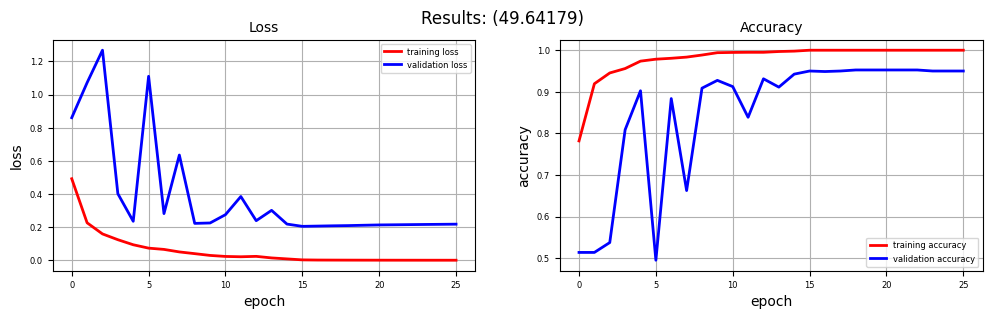

Accuracy - (Exploration (50x50) 02) - Threshold(0.50): Train(98.58)	Test(94.67)
Accuracy - (Exploration (50x50) 02) - Threshold(0.90): Train(97.42)	Test(93.30)
Accuracy - (Exploration (50x50) 02) - Threshold(0.99): Train(93.75)	Test(89.33)
Session: 2-Exploration (50x50) 03


E0000 00:00:1744036699.120033  644031 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


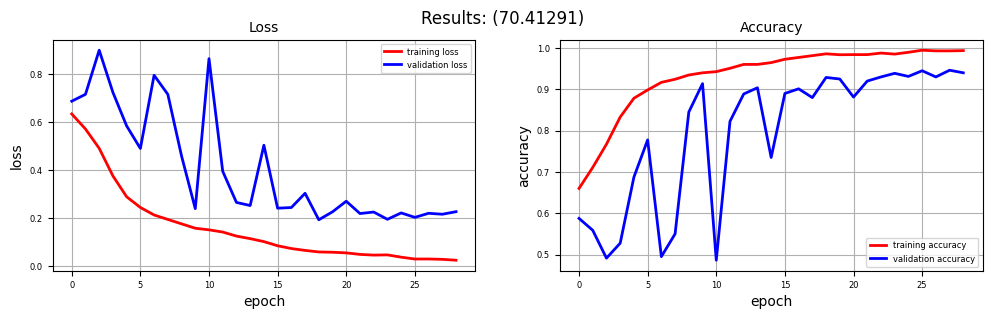

Accuracy - (Exploration (50x50) 03) - Threshold(0.50): Train(96.23)	Test(92.35)
Accuracy - (Exploration (50x50) 03) - Threshold(0.90): Train(91.57)	Test(89.00)
Accuracy - (Exploration (50x50) 03) - Threshold(0.99): Train(79.70)	Test(78.72)
Session: 3-Exploration (50x50) 04


E0000 00:00:1744036776.142283  644031 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


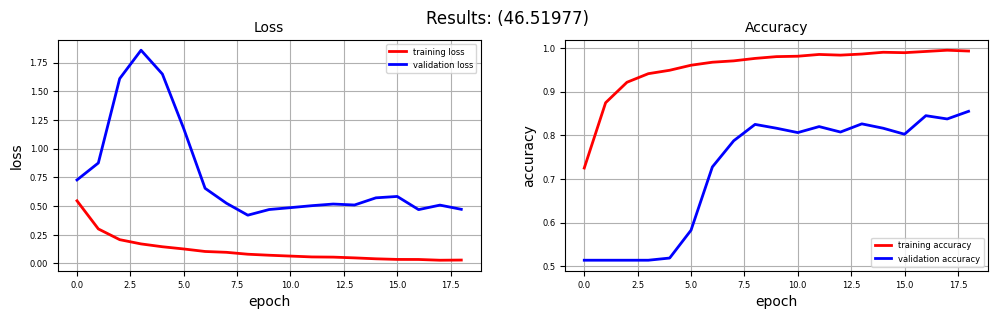

Accuracy - (Exploration (50x50) 04) - Threshold(0.50): Train(83.58)	Test(83.47)
Accuracy - (Exploration (50x50) 04) - Threshold(0.90): Train(67.65)	Test(67.25)
Accuracy - (Exploration (50x50) 04) - Threshold(0.99): Train(52.50)	Test(52.35)
Session: 4-Exploration (50x50) 05
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


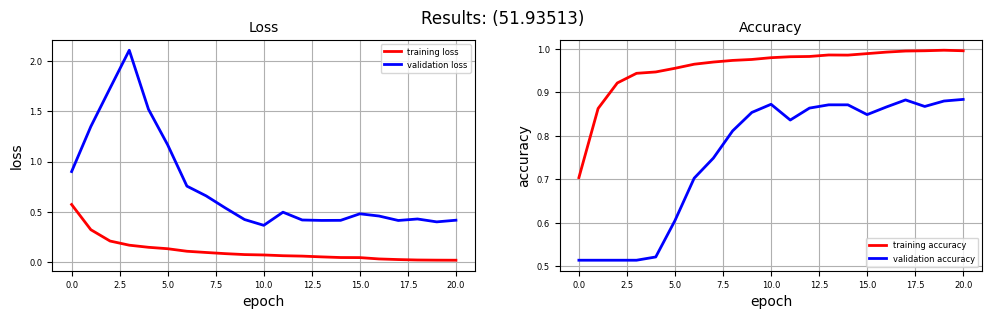

Accuracy - (Exploration (50x50) 05) - Threshold(0.50): Train(87.65)	Test(87.83)
Accuracy - (Exploration (50x50) 05) - Threshold(0.90): Train(75.52)	Test(75.88)
Accuracy - (Exploration (50x50) 05) - Threshold(0.99): Train(57.17)	Test(56.27)
Session: 5-Exploration (50x50) 06


E0000 00:00:1744036884.407091  644031 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


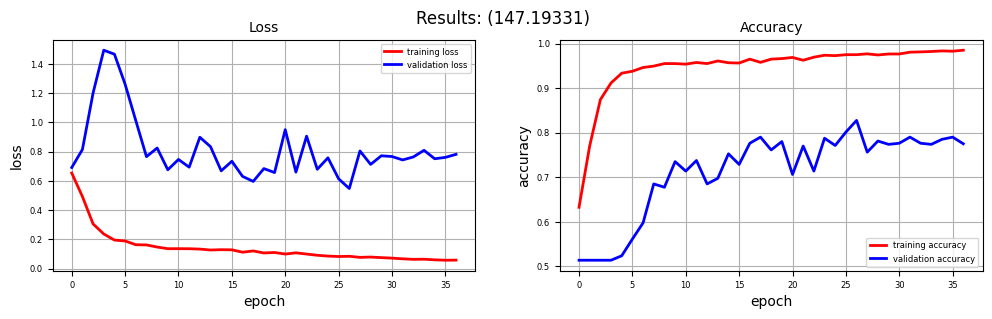

Accuracy - (Exploration (50x50) 06) - Threshold(0.50): Train(82.35)	Test(81.67)
Accuracy - (Exploration (50x50) 06) - Threshold(0.90): Train(74.22)	Test(74.00)
Accuracy - (Exploration (50x50) 06) - Threshold(0.99): Train(58.50)	Test(57.53)
Session: 6-Exploration (50x50) 07
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


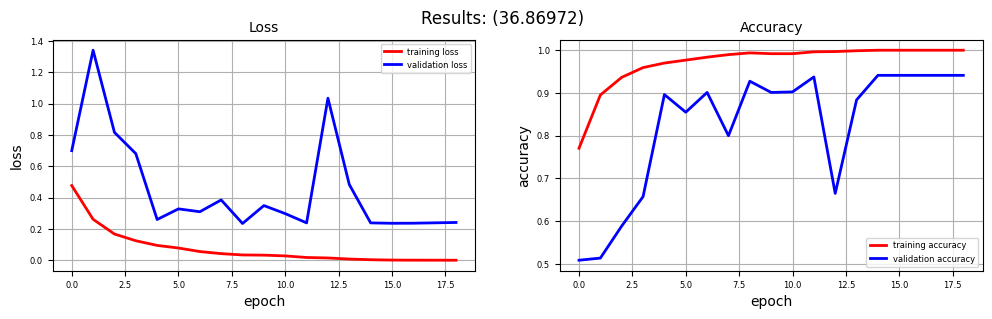

Accuracy - (Exploration (50x50) 07) - Threshold(0.50): Train(95.55)	Test(92.27)
Accuracy - (Exploration (50x50) 07) - Threshold(0.90): Train(89.35)	Test(86.30)
Accuracy - (Exploration (50x50) 07) - Threshold(0.99): Train(75.72)	Test(73.60)
Session: 7-Exploration (50x50) 08
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


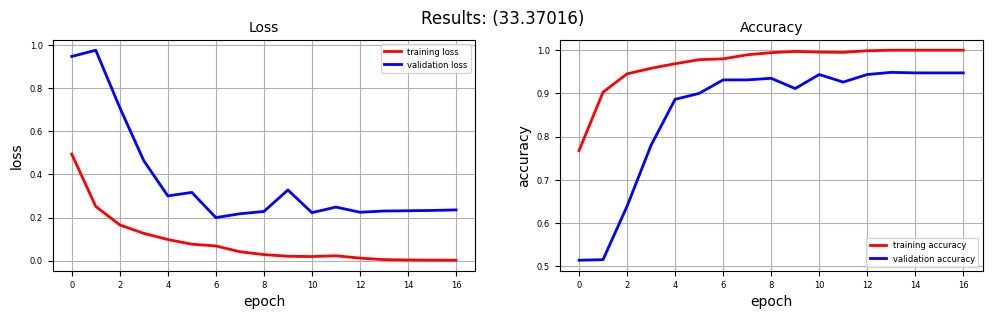

Accuracy - (Exploration (50x50) 08) - Threshold(0.50): Train(96.50)	Test(93.08)
Accuracy - (Exploration (50x50) 08) - Threshold(0.90): Train(88.15)	Test(85.22)
Accuracy - (Exploration (50x50) 08) - Threshold(0.99): Train(67.45)	Test(66.03)
Session: 8-Exploration (50x50) 09
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


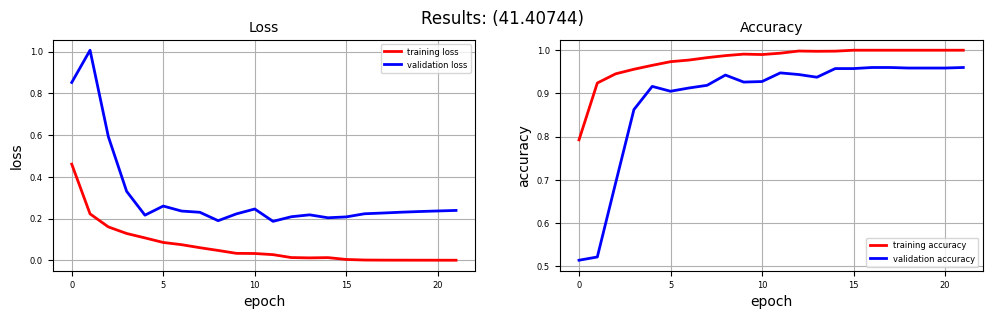

Accuracy - (Exploration (50x50) 09) - Threshold(0.50): Train(97.60)	Test(94.27)
Accuracy - (Exploration (50x50) 09) - Threshold(0.90): Train(95.10)	Test(91.62)
Accuracy - (Exploration (50x50) 09) - Threshold(0.99): Train(87.58)	Test(83.97)
Session: 9-Exploration (50x50) 10
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


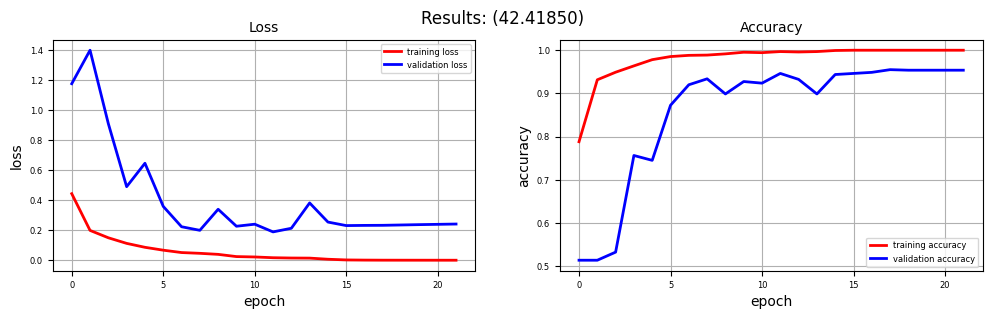

Accuracy - (Exploration (50x50) 10) - Threshold(0.50): Train(97.22)	Test(93.53)
Accuracy - (Exploration (50x50) 10) - Threshold(0.90): Train(93.97)	Test(90.77)
Accuracy - (Exploration (50x50) 10) - Threshold(0.99): Train(84.55)	Test(82.55)
Session: 10-Exploration (50x50) 11
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


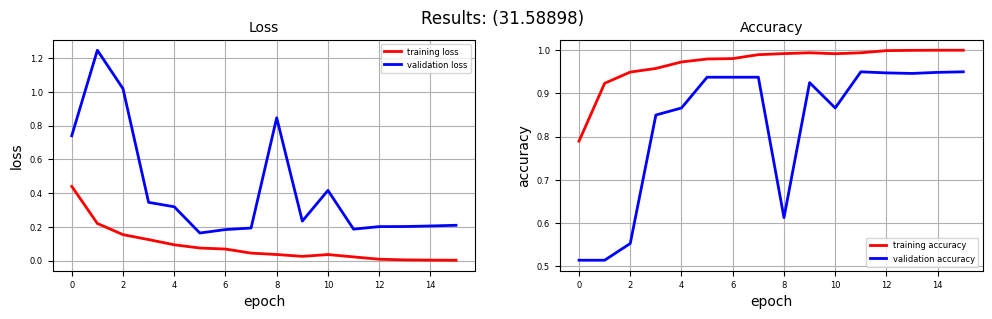

Accuracy - (Exploration (50x50) 11) - Threshold(0.50): Train(95.47)	Test(92.03)
Accuracy - (Exploration (50x50) 11) - Threshold(0.90): Train(93.38)	Test(89.98)
Accuracy - (Exploration (50x50) 11) - Threshold(0.99): Train(72.22)	Test(70.53)
Session: 11-Exploration (50x50) 12
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


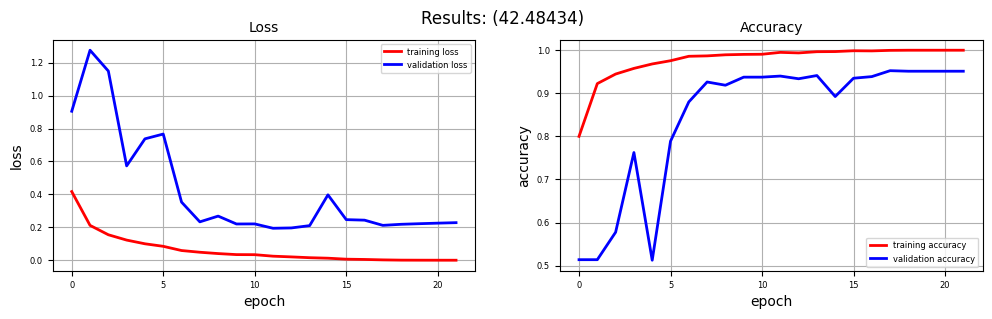

Accuracy - (Exploration (50x50) 12) - Threshold(0.50): Train(97.82)	Test(93.55)
Accuracy - (Exploration (50x50) 12) - Threshold(0.90): Train(96.70)	Test(93.17)
Accuracy - (Exploration (50x50) 12) - Threshold(0.99): Train(90.55)	Test(87.55)
Session: 12-Exploration (50x50) 13
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


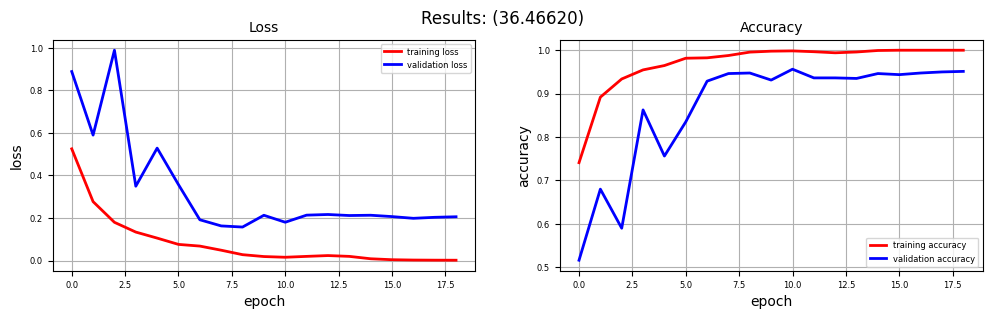

Accuracy - (Exploration (50x50) 13) - Threshold(0.50): Train(97.60)	Test(93.83)
Accuracy - (Exploration (50x50) 13) - Threshold(0.90): Train(93.15)	Test(89.08)
Accuracy - (Exploration (50x50) 13) - Threshold(0.99): Train(77.68)	Test(75.28)
Session: 13-Exploration (50x50) 14
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


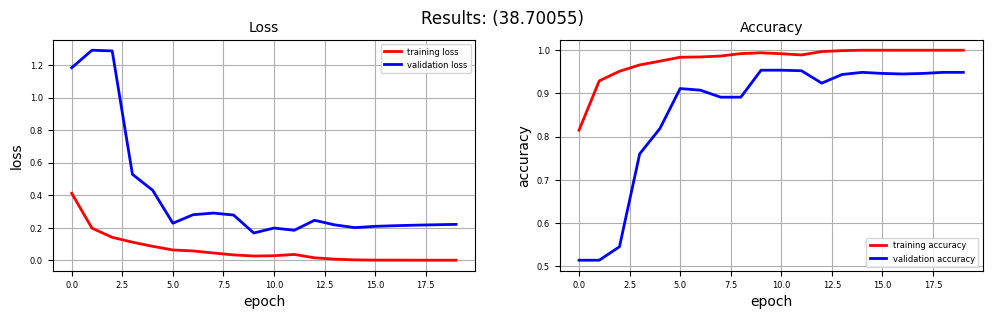

Accuracy - (Exploration (50x50) 14) - Threshold(0.50): Train(97.90)	Test(94.08)
Accuracy - (Exploration (50x50) 14) - Threshold(0.90): Train(95.90)	Test(92.42)
Accuracy - (Exploration (50x50) 14) - Threshold(0.99): Train(88.98)	Test(85.97)
Session: 14-Exploration (50x50) 15
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


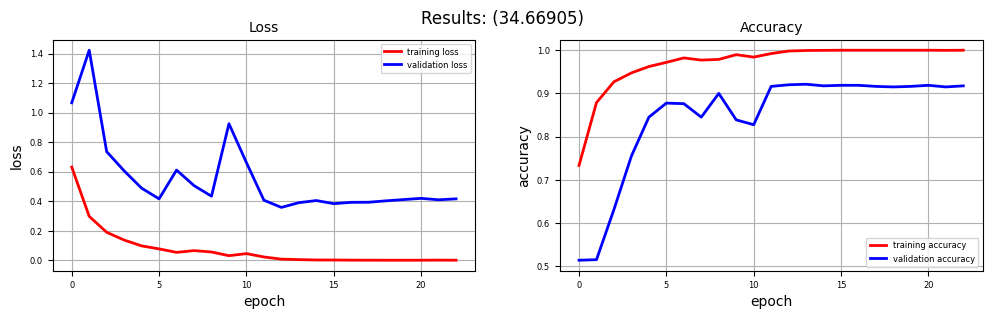

Accuracy - (Exploration (50x50) 15) - Threshold(0.50): Train(97.70)	Test(91.03)
Accuracy - (Exploration (50x50) 15) - Threshold(0.90): Train(96.53)	Test(89.95)
Accuracy - (Exploration (50x50) 15) - Threshold(0.99): Train(93.12)	Test(87.15)
Session: 15-Exploration (50x50) 16
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


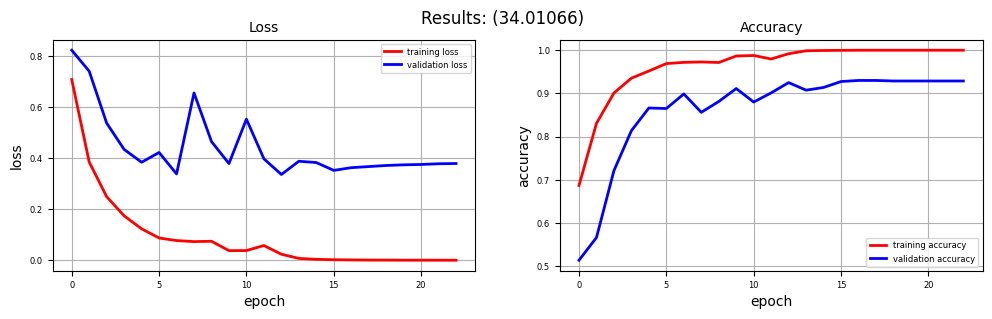

Accuracy - (Exploration (50x50) 16) - Threshold(0.50): Train(97.92)	Test(91.03)
Accuracy - (Exploration (50x50) 16) - Threshold(0.90): Train(96.47)	Test(89.50)
Accuracy - (Exploration (50x50) 16) - Threshold(0.99): Train(93.42)	Test(86.40)
Session: 16-Exploration (50x50) 17
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


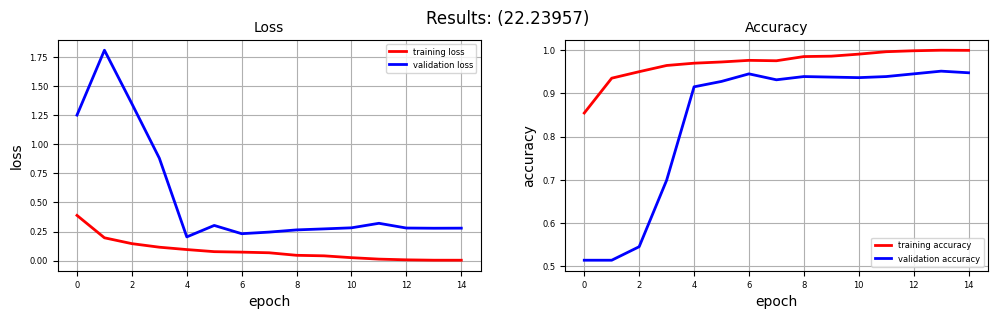

Accuracy - (Exploration (50x50) 17) - Threshold(0.50): Train(94.33)	Test(91.53)
Accuracy - (Exploration (50x50) 17) - Threshold(0.90): Train(89.70)	Test(87.52)
Accuracy - (Exploration (50x50) 17) - Threshold(0.99): Train(80.83)	Test(79.35)
Session: 17-Exploration (50x50) 18
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


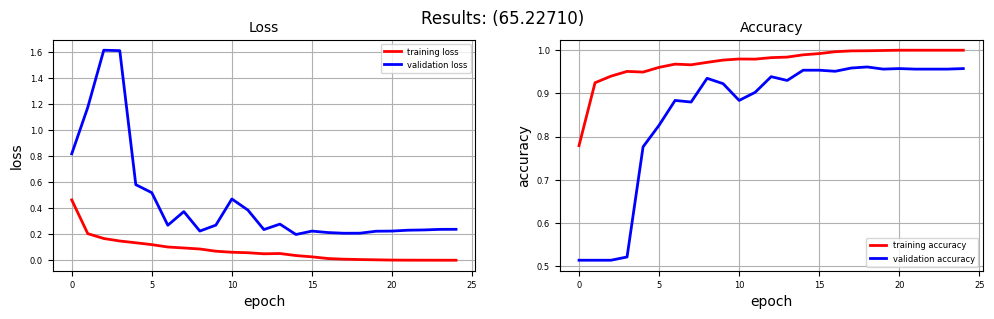

Accuracy - (Exploration (50x50) 18) - Threshold(0.50): Train(97.92)	Test(94.55)
Accuracy - (Exploration (50x50) 18) - Threshold(0.90): Train(96.75)	Test(93.42)
Accuracy - (Exploration (50x50) 18) - Threshold(0.99): Train(91.90)	Test(89.40)
Session: 18-Exploration (50x50) 19
---> dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


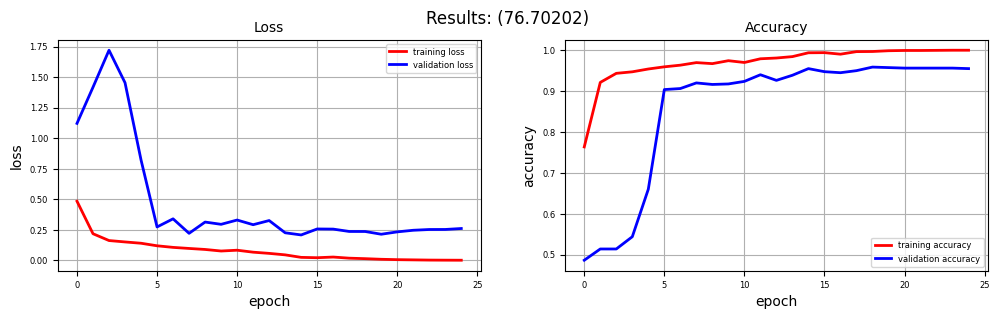

Accuracy - (Exploration (50x50) 19) - Threshold(0.50): Train(97.22)	Test(93.88)
Accuracy - (Exploration (50x50) 19) - Threshold(0.90): Train(95.28)	Test(92.70)
Accuracy - (Exploration (50x50) 19) - Threshold(0.99): Train(90.10)	Test(87.92)
Exploration (50x50) 01	threshold:	0.50	Train:	98.62	Test:	94.30)
Exploration (50x50) 01	threshold:	0.90	Train:	97.47	Test:	93.42)
Exploration (50x50) 01	threshold:	0.99	Train:	94.60	Test:	89.92)
Exploration (50x50) 02	threshold:	0.50	Train:	98.58	Test:	94.67)
Exploration (50x50) 02	threshold:	0.90	Train:	97.42	Test:	93.30)
Exploration (50x50) 02	threshold:	0.99	Train:	93.75	Test:	89.33)
Exploration (50x50) 03	threshold:	0.50	Train:	96.23	Test:	92.35)
Exploration (50x50) 03	threshold:	0.90	Train:	91.57	Test:	89.00)
Exploration (50x50) 03	threshold:	0.99	Train:	79.70	Test:	78.72)
Exploration (50x50) 04	threshold:	0.50	Train:	83.58	Test:	83.47)
Exploration (50x50) 04	threshold:	0.90	Train:	67.65	Test:	67.25)
Exploration (50x50) 04	threshold:	0.99	Train:

In [16]:
# Perform the search
collected_results = []
for i, m in enumerate(malaria_models):
    if m is None:
        continue

    print(f"Session: {i}-{getattr(m, 'howest', 'xx')}")
    # een kopy nemen van de originele data om mee te werken
    # de resultaten zijn voor hetzelfde net verschillend, waarom??
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    y_train_copy = y_train.copy()
    y_test_copy = y_test.copy()
    training_history, training_time = train_malaria_model(
        model=m,
        X_train_input=X_train_copy, y_train_input=y_train_copy,
        description=f"{i}-{getattr(m, 'howest', 'xx')}",
        verbose=0,
    )
    plot_history(training_history, training_time)  
    for threshold in [0.5, 0.9, 0.99]:
        collected_results.append(
            collect_accuracy(
                model=m,
                X_train_input=X_train_copy, y_train_input=y_train_copy,
                X_test_input=X_test_copy, y_test_input=y_test_copy,
                decision_boundary=threshold,
                verbose=0,
            )
        )

# Summary
for n, t, train_a, test_a in collected_results:
    print(f"{n}\tthreshold:\t{t:.2f}\tTrain:\t{train_a:.2f}\tTest:\t{test_a:.2f})")



In [17]:
# Visualiseer enkele verkeerd geclassificeerde afbeeldingen van de ene klasse en van de andere klasse. 


In [18]:
# Verminderen van het aantal false negatives tot max 1%.



**Schrijf hier jouw conclusies:**



### Transfer learning
Hertrain het VGG19 netwerk (of optioneel ResNet) op de malaria dataset. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.

In [19]:
# transfer learning


#modelVGG19 = tf.keras.applications.vgg19.VGG19()
modelVGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(100,100,3))
type(modelVGG19)


# Converteer naar een sequential model.


    
# Zet de gewichten van feature extraction layers vast.


# Voeg dense layers toe.


keras.src.models.functional.Functional

---
### Conclusies malaria experiment


---
---
## Face recognition

Train een eigen CNN dat als taak heeft een zo accuraat mogelijke gezichtsherkenning uit te voeren op een gezichtsdataset van celebrities.

Er zijn twee gezichtsdatasets beschikbaar:

'./Face_Recognition/15_Classes' bevat gezichten van 15 verschillende celbrities.
'./Face_Recognition/100_Classes' bevat gezichten van 100 verschillende celebrities.

Werk in eerste instantie met de 15_classes dataset. 


### 15 classes dataset - eigen CNN

In [20]:
# Inlezen en preprocessen van de afbeeldingen
# nr_of_images = 5000
image_size = 100


faces = []
labels = []
# read infected train_images
path = './Face_Recognition/15_Classes'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    faces.append(im)
    #s = re.sub('[0-9]\w+', '', f)
    s = os.path.splitext(f)[0]
    s = ''.join([i for i in s if not i.isdigit()])
    s = s.replace("_", "")
    labels.append(s)

In [21]:
# Creëer een training set en test set. Zorg ervoor dat 30 procent van de afbeeldingen in de test set zitten.



In [22]:
# Convolutional Neural Network



In [23]:
# Testen van het CNN



In [24]:
# Hyperparameter tuning en image augmentation. 


**Schrijf hier jouw conclusies neer:**

### Transfer learning by means of VGG19

Hertrain een VGG19 net (of Resnet).

In [25]:
# VGG19


**Schrijf hier jouw conclusies neer:**

### 100 classes dataset

Probeer nu classificatie te doen op de 100_classes dataset. Tranfer learning hoeft niet. Vergelijk de resultaten met de performantie op de 15_classes dataset. Evalueer en verklaar de resultaten.

In [26]:
# Herkenning van 100 classes dataset



**Schrijf hier jouw conclusies neer:**

## Face detection 


Het doel is het ontwerpen van een CNN die met een hoge accuraatheid in staat is om gezichten te detecteren waarna rond het gezicht een bounding box getekend wordt. 
Bijvoorbeeld:
![alt text](./Jupyter_Images/Face_Detection.png) 

Doorloop de volgede stappen:
- Compileer een training set met gezichten en niet-gezichten. Online zijn verschillende gezichtsdatasets te vinden. Bijvoorbeeld: https://lionbridge.ai/datasets/5-million-faces-top-15-free-image-datasets-for-facial-recognition/ en http://shuoyang1213.me/WIDERFACE/
- Train een CNN (mag via transfer learning, maar hoeft niet) die met een hoge accuraatheid gezichten van niet-gezichten kan onderscheiden.
- Test deze CNN om een idee te hebben van de classifiation accuracy. 
- Indien de performantie voldoende hoog is kan je een sliding window detector implementeren. Dit betekent dat je de test-afbeelding meerdere keren afscant met een sliding window van verschillende groottes. Het CNN zal voor elke positie van het sliding window een classificatie doen van de subimage die onder het window is gelegen. Teken een bounding box wanneer de subimage een gezicht bevat.

Voor het tekenen van een bounding box kan de volgende code gebruikt worden:

```python
def rectangle_perimeter(r0, c0, width, height, shape=None, clip=False):
    rr, cc = [r0, r0 + width, r0 + width, r0], [c0, c0, c0 + height, c0 + height]
    return skimage.draw.polygon_perimeter(rr, cc, shape=shape, clip=clip)

# drawing the bounding box:
rr, cc = rectangle_perimeter(y, x, w, w)
image_detected[rr,cc] =255

```

Extra uitbreiding:

Probleem: omdat we de afbeelding meerdere keren afscannen, telkens met windows van verschillende grootte is het goed mogelijk dat er meerdere bounding boxes worden geteked rond hetzelfde gezicht. Zoek naar een manier om meerdere bounding boxes die bij hetzelfde gezicht horen samen te voegen tot 1 bounding box.
Een veel gebruikte techniek is Non-Maximum Suppression: https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/ en https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/.